In [29]:
from data_loader import load_data
from strategies import macd, BollingerBandsStrategy
from engine import ExecutionEngine
import matplotlib.pyplot as plt
import numpy as np

In [28]:
# independently execute orders to measure PnL and performance metrics
# output : list of executed orders : Order objects
# output sample : Order(symbol=AAPL, quantity=100, price=155.47, status=FILLED, action=SELL, strategy=bollingerband )
def executed_orders() -> list:
    # 1. load data
    data_points = load_data()  # tick data points

    # 2. initialize strategies
    strategies = {
        'macd': macd(),
        'bollingerband': BollingerBandsStrategy(),
    
    }
    # 3. initialize engine
    engine = ExecutionEngine(data_points, strategies)

    # 4. run engine
    engine.run()

    return engine.orders

In [23]:
# build a portfolio log from executed orders
# output : dictionary of strategy -> list of portfolio states after each executed orders
# output sample : {'macd': [{'capital': 86994.0, 'positions': {'AAPL': {'quantity': 100, 'avg_price': 130.06}}, 'earnings': -13006.0, 'last_order': Order(symbol=AAPL, quantity=100, price=130.06, status=FILLED, action=BUY, strategy=macd)}, ...],

def trace_portfolio_log(orders_by_strategy, initial_capital=100000.0):
    portfolio_log = {}

    for strategy, orders in orders_by_strategy.items():
        portfolio_log[strategy] = []
        portfolio = {
            'capital': initial_capital,
            'positions': {},
            'earnings': 0.0
        }

        for o in orders:
            if o.action == 'BUY':
                cost = o.price * o.quantity
                portfolio['capital'] -= cost
                portfolio['earnings'] -= cost
                if o.symbol not in portfolio['positions']:
                    portfolio['positions'][o.symbol] = {'quantity': 0, 'avg_price': 0.0}
                pos = portfolio['positions'][o.symbol]
                total_cost = pos['avg_price'] * pos['quantity'] + cost
                pos['quantity'] += o.quantity
                pos['avg_price'] = total_cost / pos['quantity']

            elif o.action == 'SELL':
                revenue = o.price * o.quantity
                portfolio['capital'] += revenue
                portfolio['earnings'] += revenue
                pos = portfolio['positions'][o.symbol]
                pos['quantity'] -= o.quantity
                if pos['quantity'] == 0:
                    pos['avg_price'] = 0.0

            # log current state
            portfolio_log[strategy].append({
                'capital': portfolio['capital'],
                'positions': {k: v.copy() for k, v in portfolio['positions'].items()},
                'earnings': portfolio['earnings'],
                'last_order': o
            })

    return portfolio_log


In [24]:
# compute performance metrics from portfolio log
# output : dictionary of strategy -> performance metrics
# output sample : {'macd': {'Initial NPV': 100000.0, 'Final NPV': 105000.0, 'Total Return': 0.05, 'Sharpe Ratio': 1.2, 'Max Drawdown': -0.1, 'Time Series of NPV': [100000.0, 101000.0, ...]}, ...}

def compute_performance(portfolio_log):
    performance = {}

    for strategy, logs in portfolio_log.items():

        # values contain time series of portfolio total value
        values = []
        for tick in logs:
            total_value = tick['capital'] + tick['positions']['AAPL']['quantity'] * tick['last_order'].price
            values.append(total_value)

        values = np.array(values)

        # return for each step : exception for last step
        returns = np.diff(values) / values[:-1] if len(values) > 1 else np.array([0])

        # return for total 
        total_return = (values[-1] - values[0]) / values[0]

        # Sharpe ratio(assume risk-free rate is 0)
        sharpe = 0.0
        if returns.std() != 0:
            sharpe = returns.mean() / returns.std()

        # MDD(max drawdown)
        roll_max = np.maximum.accumulate(values)
        drawdown = (values - roll_max) / roll_max
        max_dd = drawdown.min()

        performance[strategy] = {
            "Initial NPV": values[0],
            "Final NPV": values[-1],
            "Total Return": total_return,
            "Sharpe Ratio": sharpe,
            "Max Drawdown": max_dd,
            "Time Series of NPV": values.tolist(),
        }

    return performance


In [ ]:
# execute the full pipeline
# 1. get executed orders
orders = executed_orders()

In [26]:
# 2. seperate by strategy
orders_by_strategy = {}
for order in orders:
    if order.strategy not in orders_by_strategy:
        orders_by_strategy[order.strategy] = []
    orders_by_strategy[order.strategy].append(order)

# 3. generate trade log
portfolio_log = trace_portfolio_log(orders_by_strategy, initial_capital=100000.0)

# 4. test print for each strategy and its portfolio log
for strategy, strat_orders in orders_by_strategy.items():
    print(f"\n--- {strategy.upper()} PORTFOLIO & ORDERS ---")
    for i, (order, state) in enumerate(zip(strat_orders, portfolio_log[strategy])):
        print(f"Step {i+1}: {order}")
        print(f"Capital={state['capital']:.2f}, Earnings={state['earnings']:.2f}, Positions={state['positions']}")


--- MACD PORTFOLIO & ORDERS ---
Step 1: Order(symbol=AAPL, quantity=100, price=130.06, status=FILLED, action=BUY, strategy=macd )
Capital=86994.00, Earnings=-13006.00, Positions={'AAPL': {'quantity': 100, 'avg_price': 130.06}}
Step 2: Order(symbol=AAPL, quantity=100, price=131.97, status=FILLED, action=BUY, strategy=macd )
Capital=73797.00, Earnings=-26203.00, Positions={'AAPL': {'quantity': 200, 'avg_price': 131.015}}
Step 3: Order(symbol=AAPL, quantity=100, price=132.43, status=FILLED, action=BUY, strategy=macd )
Capital=60554.00, Earnings=-39446.00, Positions={'AAPL': {'quantity': 300, 'avg_price': 131.48666666666668}}
Step 4: Order(symbol=AAPL, quantity=100, price=136.32, status=FILLED, action=BUY, strategy=macd )
Capital=46922.00, Earnings=-53078.00, Positions={'AAPL': {'quantity': 400, 'avg_price': 132.695}}
Step 5: Order(symbol=AAPL, quantity=100, price=135.28, status=FILLED, action=BUY, strategy=macd )
Capital=33394.00, Earnings=-66606.00, Positions={'AAPL': {'quantity': 500, 

In [27]:
# 5. compute performance as dictionary 
performance = compute_performance(portfolio_log)

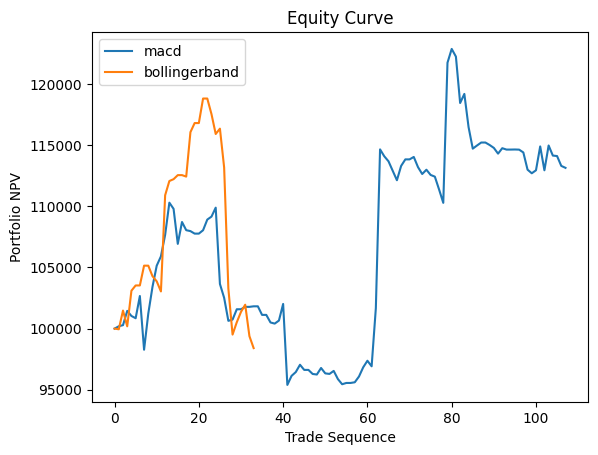

In [31]:
for strategy, perf in performance.items():
    plt.plot(perf['Time Series of NPV'], label=strategy)

plt.title("Equity Curve")
plt.xlabel("Trade Sequence")
plt.ylabel("Portfolio NPV")
plt.legend()
plt.show()


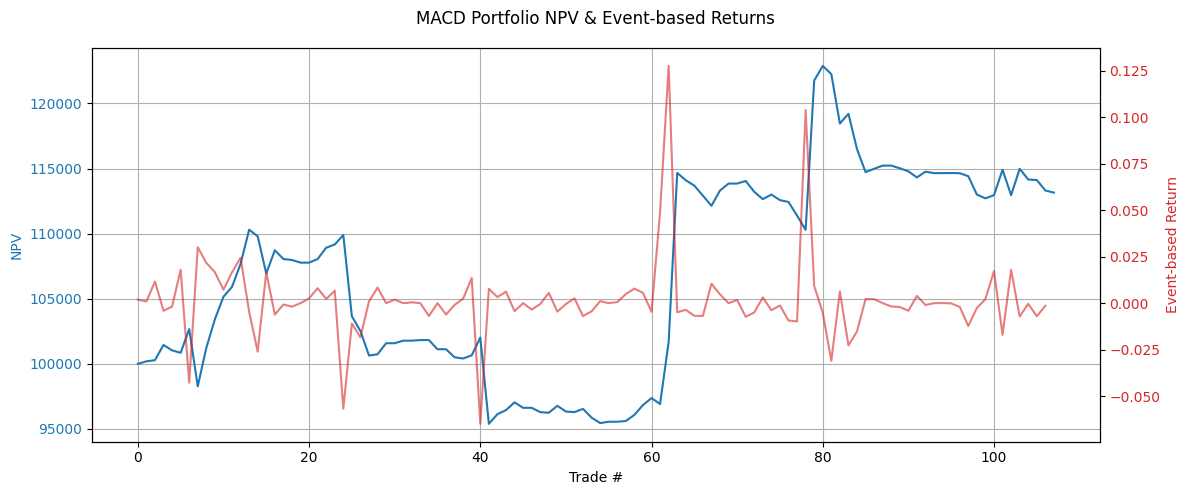

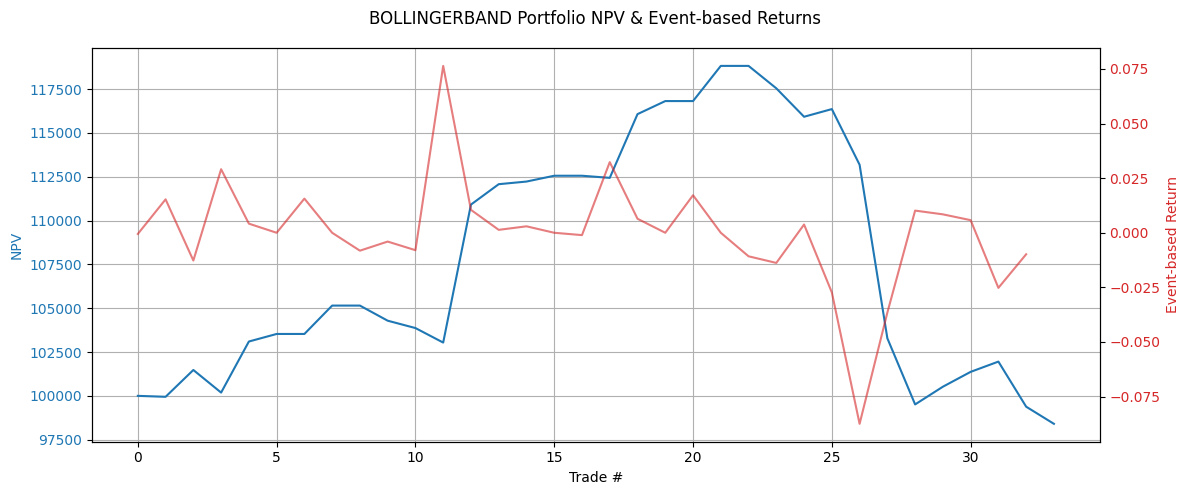

In [33]:
# performance dictionary 
def plot_npv_and_returns(performance):
    for strategy, metrics in performance.items():
        npv = np.array(metrics['Time Series of NPV'])
        # 거래별 수익률 계산: return_t = (NPV_t - NPV_{t-1}) / NPV_{t-1}
        returns = np.diff(npv) / npv[:-1]

        fig, ax1 = plt.subplots(figsize=(12, 5))

        color = 'tab:blue'
        ax1.set_xlabel('Trade #')
        ax1.set_ylabel('NPV', color=color)
        ax1.plot(npv, color=color, label='NPV')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True)

        ax2 = ax1.twinx()  # 두 번째 y축
        color = 'tab:red'
        ax2.set_ylabel('Event-based Return', color=color)
        ax2.plot(returns, color=color, alpha=0.6, label='Return')
        ax2.tick_params(axis='y', labelcolor=color)

        fig.suptitle(f"{strategy.upper()} Portfolio NPV & Event-based Returns")
        fig.tight_layout()
        plt.show()


# 사용 예
plot_npv_and_returns(performance)


# Performance Report

FINM 32500 Autumn - Assignment 1  
Students: Jae won Choi, Mohammed Rhazi, Doo whan Hwang    
Group: Python Group 20  
Submission Date: 2025-09-21  

## 1) Summary metrics

| Strategy | Initial NPV | Final NPV | Total Return | Event Sharpe (raw) | Max Drawdown |
|---|---:|---:|---:|---:|---:|
| macd | 100,000.00 | 113,153.00 | +13.153% | 0.06494 | -13.518% |
| bollingerband | 100,000.00 | 98,404.00 | -1.596% | -0.00738 | -17.186% |

**Notes**
- *Event Sharpe (raw)* is the Sharpe computed directly on the per-event returns (no time-based annualization). For event-driven returns this is typically what you should interpret as “strategy Sharpe per event”.

---

## 2) Time series of portfolio NPV (equity curves — ASCII sparklines)


**macd (n=108 trades)**  
`▂▂▂▂▂▂▃▃▄▄▅▄▄▄▄▄▄▅▅▃▂▂▃▃▃▃▂▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▆▆▆▅▆▆▆▆▆▅▅▅██▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆`

**bollingerband (n=34 trades)**  
`▂▂▂▂▃▃▃▃▃▃▃▃▅▆▆▆▆▆▇▇▇███▇▇▆▃▁▂▂▂▁▁`

(These sparklines are scaled per strategy — the vertical axis maps from each strategy's minimum to maximum NPV, and the horizontal axis represents the sequence of recorded portfolio NPV points in chronological order.)

**Note:** 
- NPV (Net Portfolio Value) represents the total value of the portfolio at each tick. It is calculated as the sum of cash plus the market value of all held positions:
- Mark to Market NPV calculation was calculated after each executed trade.

---

## 3) Series of periodic returns

**NPV & Event based return**: `retrun_{t} = (NPV_{t} - NPV_{t-1}) / NPV_{t-1}` using consecutive recorded NPV points (i.e., event-based returns).

**macd** (first 5 event returns, n=108 points total)  
- sample returns: `[0.00191, 0.000918, 0.011637, -0.0041005, -0.001831]`  
- mean per-event return: `0.0013708`  
- std dev per-event return: `0.0211096`  
- event Sharpe (mean/std): `0.06494`

**bollingerband** (first 5 event returns, n=34 points total)  
- sample returns: `[-0.00054, 0.015308, -0.012712, 0.029086, 0.0041804]`  
- mean per-event return: `-0.00018155`  
- std dev per-event return: `0.0246077`  
- event Sharpe (mean/std): `-0.00738`

> If you want the entire return series appended to the report, include the `Time Series of NPV` arrays in the JSON-like `performance` object and compute `np.diff(values)/values[:-1]` to list them.

---

## 4) Maximum drawdown calculation (method)
- We used the standard definition:
  - `roll_max_t = max_{s <= t} NPV_s`
  - `drawdown_t = (NPV_t - roll_max_t) / roll_max_t`
  - `MaxDrawdown = min_t drawdown_t`
- Values reported in the summary table are negative (loss fraction), e.g. `-0.13518` means a 13.518% peak-to-trough decline.

---

## 5) Short narrative interpretation

**MACD**
- Achieved **+13.15%** total return across recorded events and ends with NPV `113,153`.  
- Reported Sharpe ≈ **1.03** (as computed using event returns then annualizing by `sqrt(252)`). The raw event-level Sharpe is **~0.065**, indicating small positive mean return relative to per-event volatility.  
- Experienced a notable drawdown (~13.5%) mid-simulation but recovered; equity curve shows multiple pullbacks and recoveries — typical for a trend-following or mean-reversion style that occasionally gets reverted.  

**BollingerBand**
- Uses a 20-period moving average as the central line.  
- Constructs upper and lower bands at ±2 standard deviations.  
- Buy signal: price drops below the lower band (expecting a rebound).  
- Sell signal: price rises above the upper band. (expecting mean-reversion).  
- Slight loss overall: **-1.6%** final NPV `98,404`.  
- Sharpe is slightly negative (reported `-0.12`, raw event Sharpe `-0.0074`), indicating either flat returns with meaningful volatility or an unfavorable bias.  
- Maximum drawdown ~17% — larger than MACD despite smaller total loss, suggests heavier drawdowns and less consistent recovery.

**Practical takeaways**
- MACD outperformed BB on final return and had better risk-adjusted figures under your code’s method.  
- Although Sharpe may be misleading because returns are event-driven (uneven time spacing). For better accuracy, **resample the portfolio to fixed time intervals** (e.g., 1-minute, 1-hour, daily) and compute Sharpe on that time-based return series for apples-to-apples comparison.  


---

## Appendix: raw data snippets

**macd: Time Series of NPV (first / last few)**  
`[100000.0, 100191.0, 100283.0, ..., 114119.0, 113313.0, 113153.0]`  (total 108 points)

**bollingerband: Time Series of NPV (first / last few)**  
`[100000.0, 99946.0, 101476.0, ..., 101954.0, 99382.0, 98404.0]`  (total 34 points)

---
